# 1. 데이터

## 1-1. 데이터 다운로드

In [4]:
import requests

url = 'https://d3s0tskafalll9.cloudfront.net/media/documents/cityscapes.zip'

r = requests.get(url)
with open('./data/cityscapes.zip', 'wb') as f:
    f.write(r.content)

In [5]:
import zipfile

with zipfile.ZipFile('./data/cityscapes.zip', 'r') as zip_ref:
    zip_ref.extractall('./data')

## 1-2. 데이터 확인

In [6]:
import os

train_path = './data/cityscapes/train'
test_path = './data/cityscapes/val'

print(f'train sample : {len(os.listdir(train_path))}')
print(f'test sample : {len(os.listdir(test_path))}')

train sample : 1000
test sample : 5


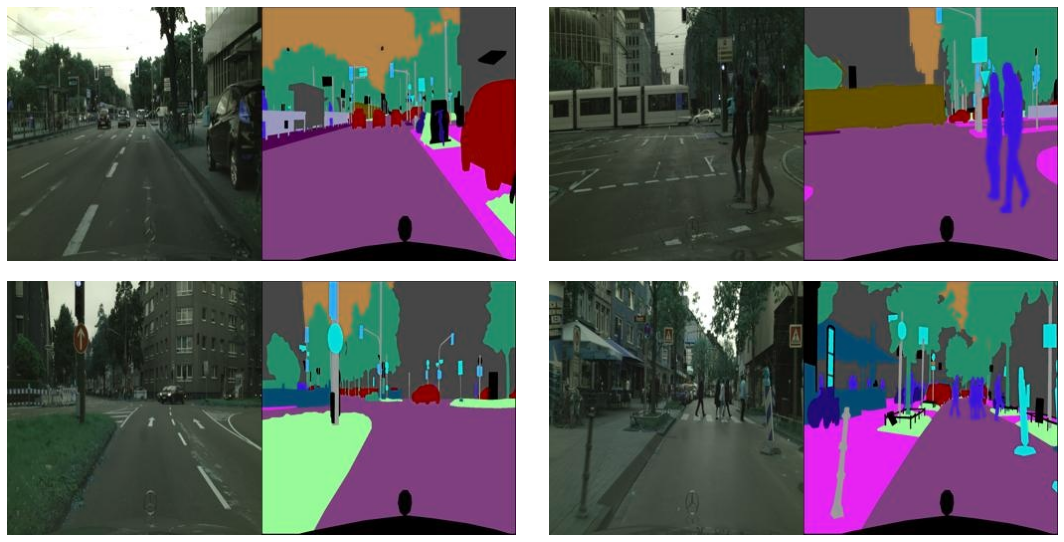

In [34]:
import matplotlib.pyplot as plt
import cv2

plt.figure(figsize=(15, 8))

for index, file in enumerate(os.listdir(train_path)[:4]):
    img = cv2.imread(f'{train_path}/{file}', cv2.IMREAD_COLOR)
    plt.subplot(2, 2, index + 1)
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(img)

In [17]:
img = cv2.imread(f'{train_path}/{os.listdir(train_path)[0]}', cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


## 1-3. 데이터 전처리

* train, label 분리

In [25]:
import tensorflow as tf
import numpy as np

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x / 127.5) - 1

def denormalize(x):
    x = (x + 1) * 127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

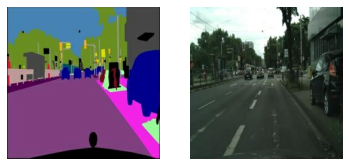

In [28]:
sketch, colored = split_image(f'{train_path}/{os.listdir(train_path)[0]}')

plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(denormalize(sketch))

plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(denormalize(colored))

plt.show()

* augmentation 적용

In [27]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:] 

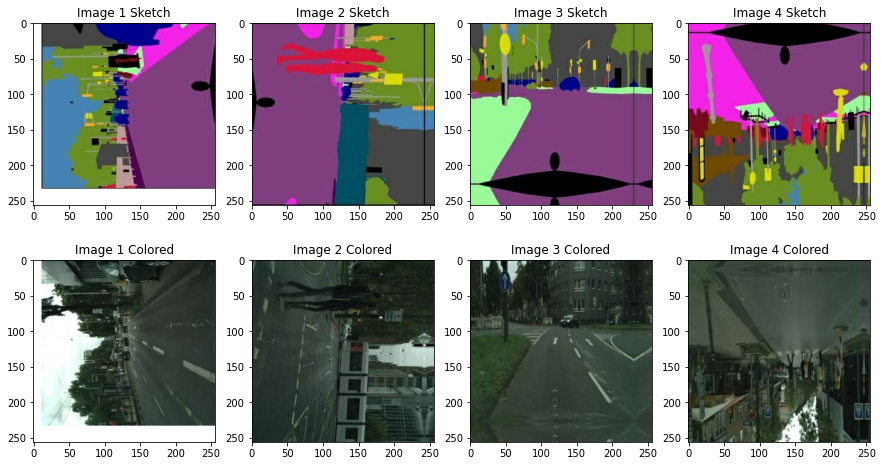

In [33]:
plt.figure(figsize=(15, 8))

for index, file in enumerate(os.listdir(train_path)[:4]):
    sketch, colored = split_image(f'{train_path}/{file}')
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(2, 4, index + 1)
    plt.imshow(denormalize(augmented_sketch))
    plt.title(f'Image {index + 1} Sketch')
    
    plt.subplot(2, 4, index + 1 + 4); 
    plt.imshow(denormalize(augmented_colored))
    plt.title(f'Image {index + 1} Colored')

In [36]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

In [38]:
train_images = data.Dataset.list_files(f'{train_path}/*.jpg')
train_images = train_images.map(get_train).shuffle(100).batch(4)

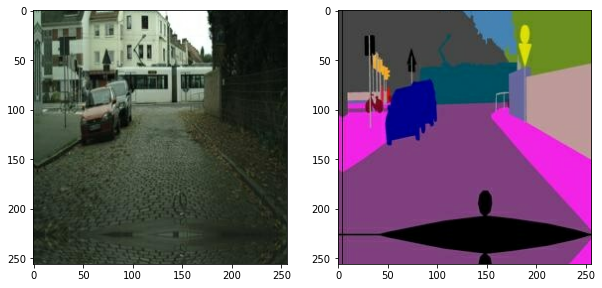

In [40]:
sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.imshow(sketch[0].astype(np.uint8))

plt.subplot(1,2,2)
plt.imshow(colored[0].astype(np.uint8))

plt.show()

# 2. 모델 구성

In [42]:
from tensorflow.keras import layers, Input, Model
from tensorflow.keras import optimizers, losses

## 2-1. Generator

In [44]:
# Encoder
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [45]:
# Decoder
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [46]:
# U-Net Generator
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64, 128, 256, 512, 512, 512, 512, 512]
        decode_filters = [512, 512, 512, 512, 256, 128, 64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]

        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256, 256, 3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [47]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

## 2-2. Discriminator

In [48]:
# DiscBlock
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [49]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()   
        filters = [64, 128, 256, 512, 1]
        self.blocks = [layers.Concatenate()]
        
        for i, f in enumerate(filters):
            self.blocks.append(DiscBlock(
                n_filters=f,
                stride=2 if i < 3 else 1,
                custom_pad=False if i < 3 else True,
                use_bn=False if i == 0 and i == 4 else True,
                act=True if i < 4 else False
            ))
        self.sigmoid = layers.Activation("sigmoid")
    
    def call(self, x, y):
        out = self.blocks[0]([x, y])
        for i in range(1, 6):
            out = self.blocks[i](out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [50]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6400        concatenate_7[0][0]        

# 3. 모델 학습

In [51]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [52]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [65]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        fake_colored = generator(sketch, training=True)

        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)

        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss)

        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [66]:
EPOCHS = 20

generator = UNetGenerator()
discriminator = Discriminator()

history = {'g_loss':[], 'l1_loss':[], 'd_loss':[]}
for epoch in range(1, EPOCHS + 1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
        
        history['g_loss'].append(g_loss)
        history['l1_loss'].append(l1_loss)
        history['d_loss'].append(d_loss)
        
        # 200회 반복마다 손실을 출력합니다.
        if (i + 1) % 200 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[200]                     
Generator_loss:0.7627                     
L1_loss:0.2070                     
Discriminator_loss:1.4619

EPOCH[2] - STEP[200]                     
Generator_loss:0.7528                     
L1_loss:0.1560                     
Discriminator_loss:1.4590

EPOCH[3] - STEP[200]                     
Generator_loss:0.7409                     
L1_loss:0.2265                     
Discriminator_loss:1.4455

EPOCH[4] - STEP[200]                     
Generator_loss:0.7420                     
L1_loss:0.1606                     
Discriminator_loss:1.4478

EPOCH[5] - STEP[200]                     
Generator_loss:0.7251                     
L1_loss:0.2052                     
Discriminator_loss:1.4169

EPOCH[6] - STEP[200]                     
Generator_loss:0.7193                     
L1_loss:0.2390                     
Discriminator_loss:1.4118

EPOCH[7] - STEP[200]                     
Generator_loss:0.7236                     
L1_loss:0.1912             

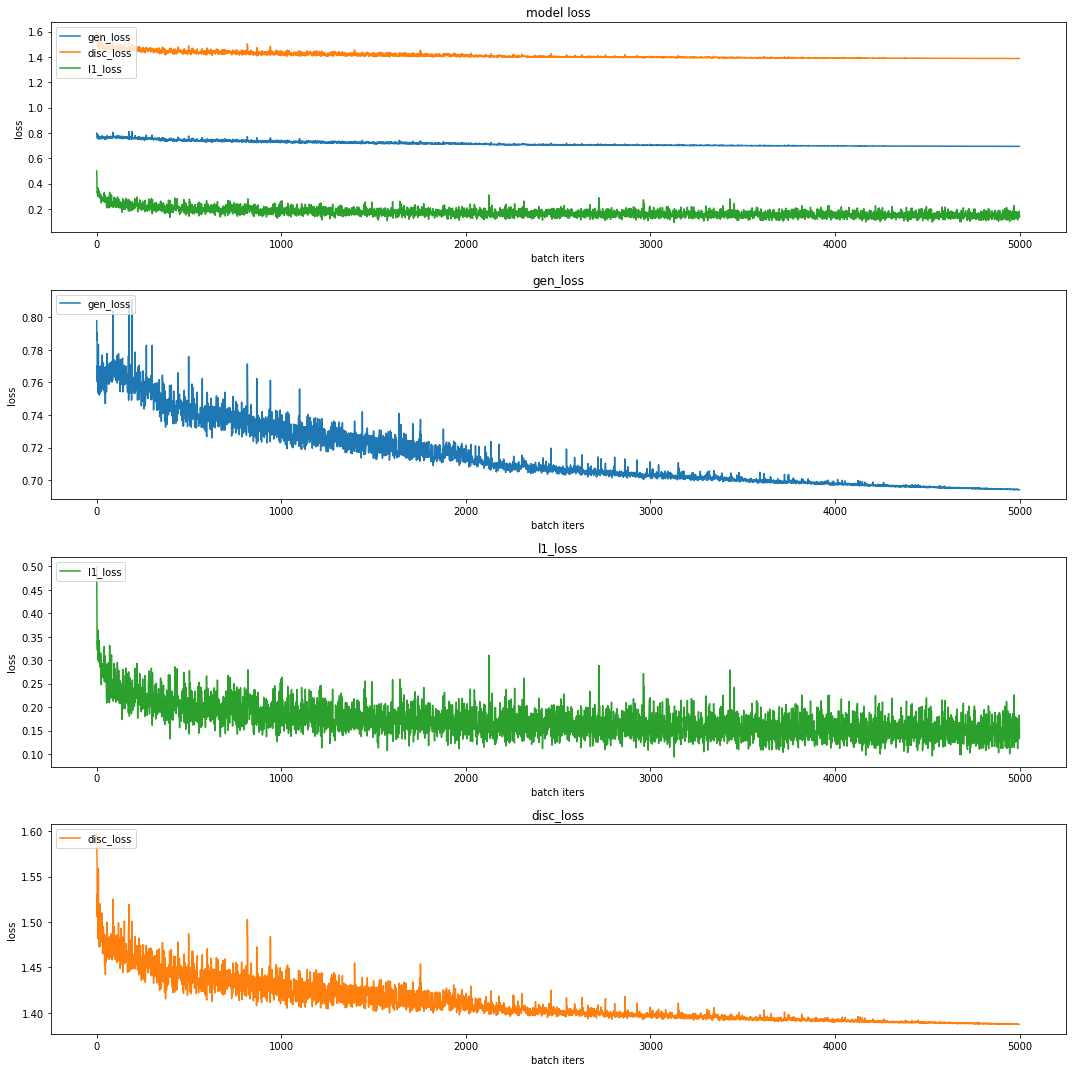

In [67]:
plt.figure(figsize=(15,15))

plt.subplot(411)  
plt.plot(history['g_loss'])  
plt.plot(history['d_loss'])
plt.plot(history['l1_loss'])
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('batch iters')  
plt.legend(['gen_loss', 'disc_loss', 'l1_loss'], loc='upper left')

plt.subplot(412)  
plt.plot(history['g_loss'], 'tab:blue')   
plt.title('gen_loss')  
plt.ylabel('loss')  
plt.xlabel('batch iters')  
plt.legend(['gen_loss'], loc='upper left')

plt.subplot(413)  
plt.plot(history['l1_loss'], 'tab:green')   
plt.title('l1_loss')  
plt.ylabel('loss')  
plt.xlabel('batch iters')  
plt.legend(['l1_loss'], loc='upper left')  

plt.subplot(414)  
plt.plot(history['d_loss'], 'tab:orange')   
plt.title('disc_loss')  
plt.ylabel('loss')  
plt.xlabel('batch iters')  
plt.legend(['disc_loss'], loc='upper left')  

plt.tight_layout()

# 4. 학습결과 테스트

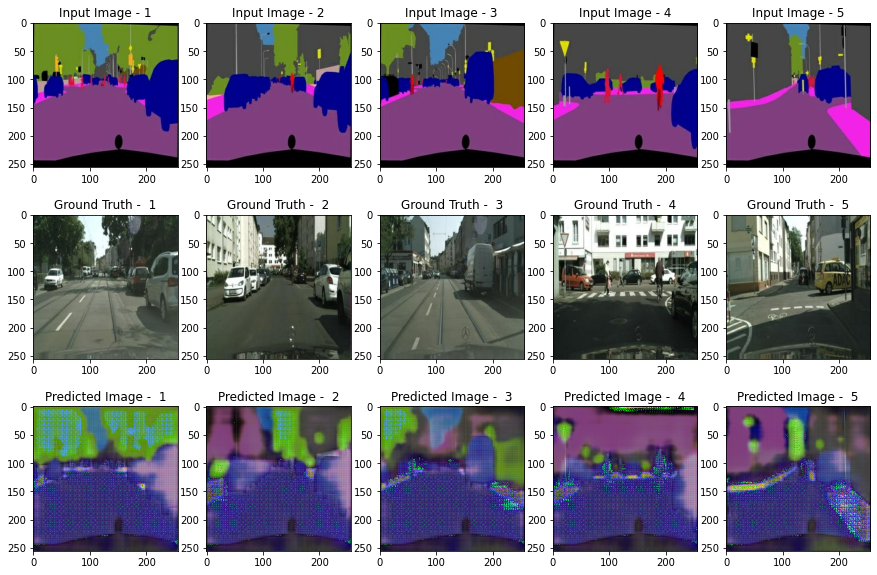

In [68]:
plt.figure(figsize=(15, 10))

test_count = len(os.listdir(test_path))
for index, file in enumerate(os.listdir(test_path)):
    sketch, colored = split_image(f'{test_path}/{file}')
    
    pred = generator(tf.expand_dims(sketch, 0))
    pred = denormalize(pred)
    
    plt.subplot(3, test_count, index + 1)
    plt.imshow(denormalize(sketch))
    plt.title(f'Input Image - {index + 1}')
    
    plt.subplot(3, test_count, index + 1 + 5)
    plt.imshow(denormalize(colored))
    plt.title(f'Ground Truth -  {index + 1}')
    
    plt.subplot(3, test_count, index + 1 + 10)
    plt.imshow(pred[0])
    plt.title(f'Predicted Image -  {index + 1}')